# Jupyter Notebook for NN Training [Traffic-based]

## Import Libraries

In [1]:
from pathlib import Path
from datetime import datetime
import os

import numpy as np
import pandas as pd
from scapy.compat import raw
from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether
from scapy.packet import Padding
from scipy import sparse

from joblib import Parallel, delayed

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.constraints import maxnorm

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

import seaborn as sn

from utils_new import should_omit_packet, read_pcap, PREFIX_TO_APP_ID, PREFIX_TO_TRAFFIC_ID

## Define Necessary Function

In [2]:
# Preprocessing
#def remove_ether_header(packet):
#    if Ether in packet:
#        return packet[Ether].payload

#    return packet


#def mask_ip(packet):
#    if IP in packet:
#        packet[IP].src = '0.0.0.0'
#        packet[IP].dst = '0.0.0.0'

#    return packet


#def pad_udp(packet):
#    if UDP in packet:
#        # get layers after udp
#       layer_after = packet[UDP].payload.copy()

        # build a padding layer
#        pad = Padding()
#        pad.load = '\x00' * 12

#        layer_before = packet.copy()
#        layer_before[UDP].remove_payload()
#        packet = layer_before / pad / layer_after

#        return packet

#    return packet


#def packet_to_sparse_array(packet):
#    arr = np.frombuffer(raw(packet), dtype=np.uint8)[0:] / 255
    #if len(arr) < max_length:
    #    pad_width = max_length - len(arr)
    #    arr = np.pad(arr, pad_width=(0, pad_width), constant_values=0)

    #arr = sparse.csr_matrix(arr)
#    return arr
def inttobit(n):
    return [1 if digit=='1' else -1 for digit in '{0:056b}'.format(n)]

def bintoint(binary):
    number = 0
    for b in binary:
        number = (2*number)+int(b)
    return number

def conv_header(proto, sport, dport, size):
    proto_bin = [int(x) for x in '{0:08b}'.format(proto)]
    sport_bin = [int(x) for x in '{0:016b}'.format(sport)]
    dport_bin = [int(x) for x in '{0:016b}'.format(dport)]
    size_bin = [int(x) for x in '{0:016b}'.format(size)]
    metric = proto_bin+sport_bin+dport_bin+size_bin
    metric_int = bintoint(metric)
    return metric, metric_int

#convert weights to binary weights and to integer
def convert_weight_to_file(weight_data, filename):
    weight= []
    weights = []
    for i in weight_data:
        for j in i:
            if j < 0:
                weight.append(0)
            else:
                weight.append(1)
        weights.append(bintoint(weight))
        weight.clear()
    txtfile = open(filename, "w")
    for i in weights:
        txtfile.write(str(i) + "\n")
    txtfile.close()


def transform_packet(packet):
    if should_omit_packet(packet):
        return None

#    packet = remove_ether_header(packet)
#    packet = pad_udp(packet)
#    packet = mask_ip(packet)
    
    ############ ADDED: Removing Payload. Leaving only IP and TCP/UDP header
#    if 'UDP' in packet:
#        packet['UDP'].remove_payload()
#    elif 'TCP' in packet:
#        packet['TCP'].remove_payload()
    #######################################################################
    if 'IP' in packet:
        size =  int(packet.len)
        try:
            proto = (packet.proto)
        except AttributeError:
            proto = 0
        try:
            sport = (packet.sport)
            dport = (packet.dport)
        except AttributeError:
            sport = 0
            dport = 0

        proto = [int(x) for x in '{0:08b}'.format(proto)]
        sport = [int(x) for x in '{0:016b}'.format(sport)]
        dport = [int(x) for x in '{0:016b}'.format(dport)]
        size =  [int(x) for x in '{0:016b}'.format(size)]
        #metric = [(proto/255), (sport/65535), (dport/65535), (size/65535)]
        metric = proto + sport + dport + size
        adapted_metric = [-1 if x == 0 else x for x in metric]
    #arr = packet_to_sparse_array(packet)
        if len(adapted_metric) == 56:
            return np.asarray(adapted_metric)

def transform_pcap(path, output_path: Path = None, output_batch_size=10000):
    if Path(str(output_path.absolute()) + '_SUCCESS').exists():
        print(output_path, 'Done')
        return
    
    start = datetime.now()
    print('########################################')

    print('Processing', path, '. Started at:', start)

    rows = []
    batch_index = 0
    #for pcap in path.iterdir():
    for i, packet in enumerate(read_pcap(path)):
        arr = transform_packet(packet)
        if arr is not None:
            # get labels for app identification
            prefix = path.name.split('.')[0].lower()
            app_label = PREFIX_TO_APP_ID.get(prefix)
            traffic_label = PREFIX_TO_TRAFFIC_ID.get(prefix)
            ###### ADDED: check if the the label exist or not
            if app_label is not None and traffic_label is not None:
                row = {
                    'app_label': app_label,
                    'traffic_label': traffic_label,
                    'feature': arr
                }
                rows.append(row)
        #print(path, 'Done')
    #print(output_path, 'Done processing')
        if rows and i > 0 and i % output_batch_size == 0:
            part_output_path = Path(str(output_path.absolute()) + f'_part_{batch_index:04d}.parquet')
            df = pd.DataFrame(rows)
            df.to_parquet(part_output_path)
            batch_index += 1
            rows.clear()
            
    if rows:
        df = pd.DataFrame(rows)
        part_output_path = Path(str(output_path.absolute()) + f'_part_{batch_index:04d}.parquet')
        df.to_parquet(part_output_path)
    
    with Path(str(output_path.absolute()) + '_SUCCESS').open('w') as f:
        f.write('')
        
    print(path, 'Done. End: ', datetime.now(), ' Processing time: ', (datetime.now()-start))
    #print('data saved')
    #return rows

       # write every batch_size packets, by default 10000
#        if rows and i > 0 and i % output_batch_size == 0:
 #           part_output_path = Path(str(output_path.absolute()) + f'_part_{batch_index:04d}.parquet')
  #          df = pd.DataFrame(rows)
   #         df.to_parquet(part_output_path)
    #        batch_index += 1
    #        rows.clear()

    # final write
#    if rows:
#        df = pd.DataFrame(rows)
#        part_output_path = Path(str(output_path.absolute()) + f'_part_{batch_index:04d}.parquet')
#        df.to_parquet(part_output_path)

    # write success file
#    with Path(str(output_path.absolute()) + '_SUCCESS').open('w') as f:
#        f.write('')


#    print(output_path, 'Done')

## Data Location

In [3]:
#pcap location
data_path = Path("thesis_data_traffic/")
output_path = Path("thesis_preprocessed_traffic/")
output_path.mkdir(parents=True, exist_ok=True)
#type(data_path)

## Process PCAP Data

In [ ]:
#transform pcap into dictionary{app_label, traffic_label, feature}
#rows = transform_pcap(data_path, output_path)
Parallel(n_jobs=1)(
    delayed(transform_pcap)(pcap_path, output_path / (pcap_path.name + '.transformed')) for pcap_path in
    sorted(data_path.iterdir()))
print('transforming pcap: finished')

## Read Data From Extracted PCAP

In [4]:
#read parquet files
data = pd.concat(
    (pd.read_parquet(parquet_file)
    for parquet_file in output_path.glob('*.parquet')),
    ignore_index=True
)


## Shuffling, Undersampling, Oversampling

In [5]:
#randomize data
data = data.sample(frac=1).reset_index(drop=True)


#convert dtype to simpler dtype
data['app_label'] = data['app_label'].astype('int8')
data['traffic_label'] = data['traffic_label'].astype('int8')

#######Undersampling (traffic label as class)
# Convert dataframe -> list
label = data['traffic_label'].tolist()
features = data['feature'].tolist()

#Undersampling several classes to 255000
rus = RandomUnderSampler(sampling_strategy={0: 252000, 1:252000, 4: 252000, 5:252000})

#Oversampling the minority to 255000
ros = RandomOverSampler(sampling_strategy={2: 252000})

#Execute undersampling and oversampling
feature_resampled, label_resampled = rus.fit_resample(features, label)
feature_resampled, label_resampled = ros.fit_resample(feature_resampled, label_resampled)

#one_hot_label_resampled = to_categorical(label_resampled, num_classes=6)


######## Simpler extraction version #########
#y_app = data['app_label'].values
#y_traffic = data['traffic_label'].values
#X = np.array(list(data['feature']), dtype=np.float32)
#############################################

###### Extract feature to X : WORKING CODE (Still consume huge memory) #####
#for i in data['feature']:
#    X_list.append(i.tolist())

#X = np.array(X_list)
#X_list.clear()
###############################################



## Train and Test Split

In [6]:
#divide train and test data
#x_train, x_test, y_train, y_test = train_test_split(np.array(list(data['feature']), dtype=np.float32), data['traffic_label'].values, test_size=0.2, random_state=1)

x_train, x_test, y_train, y_test = train_test_split(np.array(feature_resampled, dtype=np.float32), np.asarray(label_resampled), test_size=0.2, random_state=1)

#x_train, x_test, y_train, y_test = train_test_split(np.array(feature_resampled, dtype=np.float32), one_hot_label_resampled,test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Build NN model

In [7]:
model = None
#build neural network structure
# dropout = layers.Dropout(0.2, input_shape=(56,))
# inputs = keras.Input(shape=(56,), name="digits")(dropout)
# x = layers.Dropout(0.5)(inputs)
# x = layers.Dense(56, activation="sigmoid", name="dense_1")(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(56, activation="sigmoid", name="dense_2")(x)
# x = layers.Dropout(0.5)(inputs)
# x = layers.Dense(56, activation="sigmoid", name="dense_3")(x)
# x = layers.Dropout(0.5)(inputs)
# x = layers.Dense(56, activation="sigmoid", name="dense_4")(x)
# # x = layers.Dense(56, activation="sigmoid", name="dense_5")(x)
# # x = layers.Dense(56, activation="sigmoid", name="dense_6")(x)
# # x = layers.Dense(56, activation="sigmoid", name="dense_7")(x)
# # x = layers.Dense(56, activation="sigmoid", name="dense_8")(x)
# outputs = layers.Dense(6, activation="softmax", name="predictions")(x)

# model = keras.Model(inputs=inputs, outputs=outputs)
model = keras.models.Sequential()
model.add(layers.Dropout(0.2))
model.add(layers.Dense(56, input_dim=56, activation="tanh", name="dense_1", kernel_constraint=maxnorm(2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(56, activation="tanh", name="dense_2", kernel_constraint=maxnorm(2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(56, activation="tanh", name="dense_3", kernel_constraint=maxnorm(2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(56, activation="tanh", name="dense_4", kernel_constraint=maxnorm(2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation="softmax", name="predictions"))

## Compile Model

In [8]:
#define optimizer, loss function, and metric
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
    #metrics=[keras.metrics.Accuracy()],
)


## Train the Model

In [9]:
#fit training model
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=20,
    verbose=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)


Epoch 1/50
7092/7092 - 21s - loss: 0.3251 - sparse_categorical_accuracy: 0.9040 - val_loss: 0.0882 - val_sparse_categorical_accuracy: 0.9818
Epoch 2/50
7092/7092 - 20s - loss: 0.2082 - sparse_categorical_accuracy: 0.9449 - val_loss: 0.0758 - val_sparse_categorical_accuracy: 0.9833
Epoch 3/50
7092/7092 - 23s - loss: 0.1938 - sparse_categorical_accuracy: 0.9490 - val_loss: 0.0703 - val_sparse_categorical_accuracy: 0.9839
Epoch 4/50
7092/7092 - 20s - loss: 0.1864 - sparse_categorical_accuracy: 0.9510 - val_loss: 0.0688 - val_sparse_categorical_accuracy: 0.9848
Epoch 5/50
7092/7092 - 21s - loss: 0.1848 - sparse_categorical_accuracy: 0.9514 - val_loss: 0.0687 - val_sparse_categorical_accuracy: 0.9844
Epoch 6/50
7092/7092 - 21s - loss: 0.1806 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.0689 - val_sparse_categorical_accuracy: 0.9830
Epoch 7/50
7092/7092 - 22s - loss: 0.1801 - sparse_categorical_accuracy: 0.9526 - val_loss: 0.0642 - val_sparse_categorical_accuracy: 0.9856
Epoch 8/50
70

## Evaluate the Model

In [ ]:
#evaluate
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

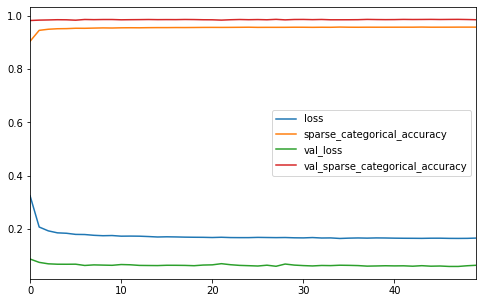

In [11]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

## Transpose and Convert Weights to File

In [14]:
#transpose weight dimension
transposed_l1 = tf.transpose(model.trainable_variables[0])
transposed_l2 = tf.transpose(model.trainable_variables[2])
transposed_l3 = tf.transpose(model.trainable_variables[4])
transposed_l4 = tf.transpose(model.trainable_variables[6])
#transposed_l5 = tf.transpose(model.trainable_variables[8])


In [15]:
convert_weight_to_file(transposed_l1, "w-l1.txt")
convert_weight_to_file(transposed_l2, "w-l2.txt")
convert_weight_to_file(transposed_l3, "w-l3.txt")
convert_weight_to_file(transposed_l4, "w-l4.txt")
#convert_weight_to_file(transposed_l5, "w-l5.txt")


#print(bintoint(weight))

## Plot Confusion Matrix

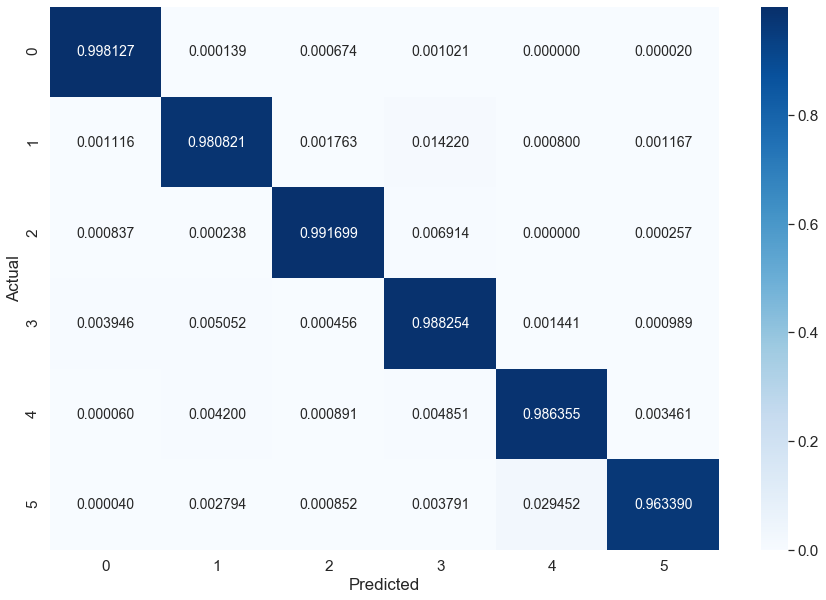

In [12]:
y_prob = model.predict(x_test)
y_classes = y_prob.argmax(axis=-1)
y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_classes, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion_norm = (df_confusion / df_confusion.sum(axis=1))


sn.set(font_scale=1.4) # for label size
plt.subplots(figsize=(15,10))
ax = sn.heatmap(df_confusion_norm, annot=True, annot_kws={"size": 14}, fmt='f', cmap=plt.cm.Blues)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

## Recall, Precision, F1 Score

In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_actu, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     50175
           1       0.99      0.98      0.98     50472
           2       1.00      0.99      0.99     50478
           3       0.97      0.99      0.98     50913
           4       0.97      0.99      0.98     49980
           5       0.99      0.96      0.98     50560

    accuracy                           0.98    302578
   macro avg       0.98      0.98      0.98    302578
weighted avg       0.98      0.98      0.98    302578



## Save Model and Weights

In [16]:
model.save('coba_bnn_56_traffic.h5')
model.save_weights('coba_bnn_56_traffic_weights.h5')

## Load Partial NN weights (based on layer name)

In [ ]:
new_inputs = keras.Input(shape=(56,), name="digits")
new_outputs = layers.Dense(6, activation="softmax", name="predictions")(new_inputs)

new_model = keras.Model(inputs=new_inputs, outputs=new_outputs)
new_model.load_weights('coba_bnn_56_traffic_weights.h5', by_name=True)

## Predict One Instance with the New Partial Model

In [ ]:
predictions = new_model.predict(np.array([inttobit(48920584543893867)]))
np.argmax(predictions[0])

## Misc

In [ ]:
coba_x = data['feature'].to_numpy()
type(coba_x)

In [ ]:
data['app_label'].unique(to_numpy'app_label'].value_counts()

In [ ]:
coba_xtrain = data['feature'][:].tolist()

In [ ]:
np.unpackbits(np.frombuffer(raw(packet[5]), dtype=np.uint8))

In [ ]:
packet[5]['TCP'].sport

In [ ]:
from utils import PREFIX_TO_APP_ID, PREFIX_TO_TRAFFIC_ID
print(len(PREFIX_TO_APP_ID))
print(len(PREFIX_TO_TRAFFIC_ID))

In [ ]:
data['traffic_label'].unique()

In [ ]:
def coba_sparse_array(packet, max_length=40):
    arr = np.frombuffer(raw(packet), dtype=np.uint8)[0: max_length] / 255
    if len(arr) < max_length:
        pad_width = max_length - len(arr)
        arr = np.pad(arr, pad_width=(0, pad_width), constant_values=0)

    arr = sparse.csr_matrix(arr)
    return arr

In [ ]:
def coba_process(path='data/icq_chat_3a.pcap'):
    packet_list = []
    for i, packet in enumerate(read_pcap(path)):
        if should_omit_packet(packet):
            pass
        packet = remove_ether_header(packet)
        if 'UDP' in packet:
            packet['UDP'].remove_payload()
        if 'TCP' in packet:
            packet['TCP'].remove_payload()
        
        
        #packet = coba_sparse_array(packet)
        #packet = mask_ip(packet)
        packet_list.append(packet)
    return packet_list

In [ ]:
arr = np.frombuffer(raw(packet[5]), dtype=np.uint8)
arr_bit = np.unpackbits(arr)
arr_bit

In [ ]:
packet = coba_process()
#packet = read_pcap('data/AIMchat2.pcapng')
#packet = remove_ether_header(packet)

In [ ]:
print(len(packet[0]['IP']))
print(len(packet[0]['TCP']))
#print(len(packet[0]['Raw']))
packet[0].show()


In [ ]:
UDP = []
for i in packet:
    if 'UDP' in i:
        UDP.append(i)

In [ ]:
print(len(UDP[0]['IP']))
print(len(UDP[0]['UDP']))
#print(len(UDP[0]['Raw']))
UDP[0].show()
#UDP

In [ ]:
ip = (packet[2]['TCP']).remove_payload()

In [ ]:
packet[3].remove_payload()
packet[3].show()

In [ ]:
import sys
sys.getsizeof(x_train[0][39])

In [ ]:
len(data['feature'])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

In [ ]:
clf  = DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [ ]:
y_pred = clf.predict(x_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
model.trainable_variables[16]

In [ ]:
model.trainable_variables

In [ ]:
max = 0
for row in data['feature']:
    if row[3] > max:
        max = row[3]
        print(row)

In [ ]:
layers.Dropout

In [17]:
from collections import Counter
print(Counter(label_resampled))
#print(len(x_train))

Counter({3: 252890, 0: 252000, 1: 252000, 2: 252000, 4: 252000, 5: 252000})


In [ ]:
y, idx, count = tf.unique_with_counts(data["traffic_label"])
print(y)
print(count)

In [ ]:
conv_header(6, 22341, 1234, 42)

In [ ]:
bintoint(str(11111001111101110011011011001111111011110001111111100111))

In [ ]:
transposed_l2[2]

In [ ]:
data['traffic_label'].unique()

In [ ]:
coba_packet = read_pcap("thesis_data_traffic/vpn_sftp_A.pcap")

In [18]:
len(label_resampled)

1512890

In [ ]:
type(y_classes)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_classes, normalize='true')

In [ ]:
def plot_cm(df_confusion, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title(title)
    #plt.figure(figsize=(8, 8))
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    

plot_cm(df_confusion_norm)

In [ ]:
import scikitplot as skplt

skplt.metrics.plot_roc_curve(y_test, y_prob)

plt.show()

In [ ]:
model.layers[5].name

In [ ]:
coba_load = tf.keras.models.load_model("coba_bnn_56_traffic.h5")

In [ ]:
coba_load.summary()

In [ ]:
results = coba_load.evaluate(x_test, y_test)
print("test loss, test acc:", results)

In [ ]:
weights_list = coba_load.get_weights()

In [ ]:
weights_list[6]

In [ ]:
model.trainable_variables

In [ ]:
len(data[])

In [ ]:
len(inttobit(312))

In [ ]:
len(predictions)